In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Get all the variable names
filename = 'GARMONfulldump_20200203.csv'
varname = list(pd.read_csv(filename, skiprows=0, nrows = 0, usecols = None).columns)
print(varname)

['DATEUTC', 'ID', 'LAT', 'LON', 'ALT', 'TEMPC', 'HUMIDITY', 'DEWPTC', 'WINDCHILLF', 'WINDDIR', 'WINDSPEEDKMH', 'WINDGUSTKMH', 'RAININ', 'DAILYRAININ', 'WEEKLYRAININ', 'MONTHLYRAININ', 'YEARLYRAININ', 'SOLARRADIATION', 'UV', 'NRECORDS', 'AGRID']


## Sort Data
Sort values in order to focus on a single data point with ascending time.
Run this routine only once and then delete the old unsorted data file.
We will use the sorted one from now on.

In [5]:
# Run this code only once and use GarmonData.csv from now on.
filename = 'GARMONfulldump_20200203.csv'
df = pd.read_csv(filename)
df = df.sort_values(['ID', 'DATEUTC'], ascending=[True, True])
filename = 'GarmonData.csv'
df.to_csv(filename, encoding='utf-8', index=False)

__Note__: Don't forget to delete the old datafile for the sake of memory

In [11]:
# read first n rows and columns
filename = 'GarmonData.csv'
# lets read the data for a week
dataFreq = 5; minperweek = 60*24*7; 
nrows_ = int(minperweek/dataFreq)
print(nrows_)
dframe1 = pd.read_csv(filename, skiprows=0, nrows = nrows_, usecols = ['TEMPC','SOLARRADIATION'])
dframe1.head(n=nrows_)

# read timestamp of the measurement (end of the 5-min interval)
dframe2 = pd.read_csv(filename, skiprows=0, nrows = nrows_, usecols = ['DATEUTC'])

2016


In [12]:
# extract data into a numpy ndarray
data = dframe1.values
time_of_day = dframe2.values

# convert time_of_day.dtype='o' to time_of_day.dtype='datetime' and extract hour
# reference: https://pbpython.com/pandas_dtypes.html
hours = pd.to_datetime(np.squeeze(time_of_day)).hour

In [13]:
# pre-processing of data

## DON'T REPLACE NAN BY MEAN -> SIMPLY ERASE THEM FOR PLOTS
# replace nan by mean values 
col_mean = np.nanmean(data, axis=0)
inds = np.where(np.isnan(data))
data[inds] = np.take(col_mean, inds[1])

# perform mean normalization
norm_data = (data-col_mean)/np.std(data, axis=0)
hours = (hours-np.mean(hours))/np.std(hours)

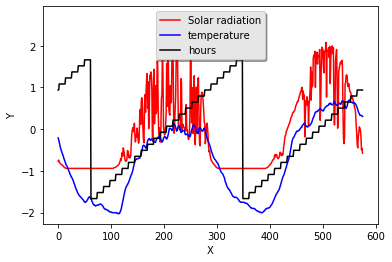

In [15]:
# simple line plot to see the correlation between solar radiation and temperature for 2 days
end = int(nrows_/7*2)
plt.plot(np.squeeze(norm_data[0:end,1]), 'r', label = "Solar radiation")
plt.plot(np.squeeze(norm_data[0:end,0]), 'b', label = "temperature")
plt.plot(np.squeeze(hours[0:end]), 'k', label = "hours")
plt.xlabel('X')
plt.ylabel('Y')
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
#plt.show()

# Heat Map

Let's check the correlation between the fields of the datasets for the first week of the measurements.


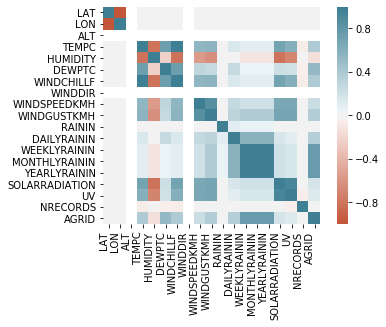

In [17]:
# read first n rows and columns
data_small = pd.read_csv(filename,skiprows=0, nrows = nrows_)
# create correlation matrix
corr = data_small.corr()
# plot correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);